# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
#### Faisal Irzal

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Rotterdam is well-known as a major logistic and economic center and has Europe's largest seaport. It is the 2nd largest city and minicipality in The Netherlands. With a population of more than 650,000 living in an area of 324 km<sup>2</sup>, Rotterdam is known for its university, riverside setting, lively culture life, maritime heritage and modern culture, and not to forget, it is a home to over 180 nationalities [1].

Having a plan to look for real estate in Rotterdam, I decided to analyse Rotterdam for this project. I am particularly interested in having the knowledge of where the best place to live in this city. In my opinion, the best place to live can be defined as the neighborhood which:
1. is residential area surrounded by nature, e.g. park, forest, lake
2. is within reach to daily essential places e.g. market places, pharmacies, public transport
3. lower population density; area with high population density is perceived low safety and environmental quality
4. affordable housing price; price should be affordable for young families to get mortgage to finance the house
5. more modern houses; assume that old houses might require renovation hence increase the cost

I understood that the criteria above may not reflect bigger population. However, in my opinion, the above categories could fit the stakeholders who just start their professional career. 

This assignment will showcase data science tools and knowledge I have gained to generate a few most promising neighborhoods based on the above criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of the problem, factors that may influence stakeholder's decision are:
* location
* population density 
* average house price
* age of the house

The following data sources will be neede to extract and generate the required information:
* list of neighborhoods in Rotterdam, its population density, age of houses in the area and the average house prices can be obtained from PDOK, a data platform for accessing geo data sets of Dutch governments [2]
* number of venues, their type and location in every neighborhood will be obtained using **Foursquare API**
* geospatial coordinate of neighborhoods in Rotterdam will be obtained by using Geocoder Python package

## Methodology <a name="methodology"></a>

GitHub repository is used in this study to store the required data. The master data contains the list of neighborhoods with its zipcodes, population density, average housing price of each neighborhood. Furthermore, geospatial coordinates will be loaded to dataframe. For this, Geocoder Python package will be used. 

First, lets import the required library to do this analysis.

In [5]:
# import required library for this analysis

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import requests
from pandas.io.json import json_normalize 

!pip install lxml
from lxml import etree

# Matplotlib and associated plotting modules
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import classification

#!pip install -U imbalanced-learn
#!pip install -U yellowbrick
#from yellowbrick.cluster import KElbowVisualizer

# install the geocoder package and import the library

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install geocoder
import geocoder

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

Prepare the required data, load them into dataframe. Add geospatial coordinates into the dataframe by using Geocoder library. Now let's load the required in **Table 1** below.

In [7]:
# Data is loaded from the available ddownloaded data
url = 'https://github.com/fifidejong/Coursera_Capstone/raw/main/Rotterdam_Data2019.xlsx'
df_rtm = pd.read_excel(url)

# Select required columns and modify the column names
df_rtm_select = df_rtm[['buurtnaam', 'meest_voorkomende_postcode', 'bevolkingsdichtheid_inwoners_per_km2', 'percentage_bouwjaarklasse_tot_2000','percentage_bouwjaarklasse_vanaf_2000','gemiddelde_woningwaarde']]
df_rtm_select = df_rtm_select.rename({"buurtnaam":"Neighborhood",
                                      "meest_voorkomende_postcode":"Postal Code",
                                      "bevolkingsdichtheid_inwoners_per_km2": "Population Density per km2",
                                      'percentage_bouwjaarklasse_tot_2000': '%-age building constructed before 2000',
                                      'percentage_bouwjaarklasse_vanaf_2000': '%-age building constructed after 2000',
                                      "gemiddelde_woningwaarde": "Average House Price in K€"}, axis='columns')

# drop the NaN/unknown input
index_names = df_rtm_select[ df_rtm_select['Average House Price in K€'] < 0 ].index 
df_rtm_select.drop(index_names, inplace=True)

# add latitude longitude information to dataframe
latitude  = []
longitude = []
for code in df_rtm_select['Postal Code']:
    g      = geocoder.arcgis('{}, Rotterdam, The Netherlands'.format(code))
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

df_rtm_select['Latitude']  = latitude
df_rtm_select['Longitude'] = longitude

print('Size of dataset = ', df_rtm_select.shape)
df_rtm_select.head()

Size of dataset =  (75, 8)


Neighborhood  Postal Code  Population Density per km2  \
0  Stadsdriehoek         3011                       12065   
1           Cool         3012                        9404   
2    Cs Kwartier         3013                        2511   
3    Oude Westen         3014                       16682   
4       Dijkzigt         3015                        1382   

   %-age building constructed before 2000  \
0                                      74   
1                                      85   
2                                     100   
3                                      98   
4                                      83   

   %-age building constructed after 2000  Average House Price in K€  \
0                                     26                        275   
1                                     15                        233   
2                                      0                        264   
3                                      2                        188   
4                                     17                        162   

    Latitude  Longitude  
0  51.917657   4.488733  
1  51.917812   4.475448  
2  51.924428   4.469980  
3  51.918257   4.468022  
4  51.912476   4.467651

Python Folium library is used to visualize geographic details of Rotterdam and its neighborhoods. With the help of geospatial coordinates, **Map 1** of Rotterdam below is created with neighborhoods superimposed on top. 

In [8]:
# use geopy library to get lat & lon of Rotterdam

address    = 'Rotterdam, The Netherlands'
geolocator = Nominatim(user_agent = 'rtm_explorer')
location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude

# create Rotterdam map with neighborhoods superimposed on top

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

map_rtm    = folium.Map(location = [latitude, longitude], zoom_start = 10)

for lat, lng, neighborhood in zip(df_rtm_select['Latitude'], df_rtm_select['Longitude'], df_rtm_select['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rtm)  

map_rtm

#### Foursquare 
Now that we have our location candidates, let's use Foursquare API to get info on venues existing in each neighborhood. Here, the Foursquare API is utilized to explore the neighborhoods and to segment them. The limit of 100 venues within the radius of 750m is set for each neigborhood from the received geospatial coordinates information. **Table 2** below shows example of the list venue names, venue categories, and their subsequent latitude and longitude information received from one inquiry we made for one neighborhood in Foursquare API.

In [9]:
# Foursquare ID
CLIENT_ID = 'PSBR41RBPPSLYTTXWKGWY2XC1CYVUAHWZYITIF2QPSJ2UQW1' # your Foursquare ID
CLIENT_SECRET = 'FFLMJOG0HZHJHYS1RENTVI13VYNE0MXXWOCQXP4GTWNFACIL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT  = 100 
radius = 750

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

## Examen the result
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#Clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name           categories        lat       lng
0            Ani & Haakien               Hostel  51.921551  4.465684
1      Miniworld Rotterdam               Museum  51.922658  4.464797
2             Madera House  Moroccan Restaurant  51.919806  4.465556
3  Lebkov & Sons Rotterdam       Sandwich Place  51.923679  4.469122
4              De IJssalon       Ice Cream Shop  51.920172  4.467403

In [10]:
print('In summary of this data, {} venues were returned by Foursquare. Furthermore, by repeating the Foursquare API inquiry to all neighborhoods in Rotterdam, a merge table of neighborhoods and venues will look like as Table 3 below'.format(nearby_venues.shape[0]))

In summary of this data, 37 venues were returned by Foursquare. Furthermore, by repeating the Foursquare API inquiry to all neighborhoods in Rotterdam, a merge table of neighborhoods and venues will look like as Table 3 below


In [11]:
#### Let's create a function to repeat the same process to all the neighborhoods in Rotterdam

def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
# write the code to run the above function on each neighborhood and create a new dataframe called leeuwd_venues

rtm_venues = getNearbyVenues(names=df_rtm_select['Neighborhood'],
                             latitudes= df_rtm_select['Latitude'],
                             longitudes=df_rtm_select['Longitude'])

# check the size of resulting data
#print(rtm_venues.shape)
rtm_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Stadsdriehoek              51.917657                4.488733   
1  Stadsdriehoek              51.917657                4.488733   
2  Stadsdriehoek              51.917657                4.488733   
3  Stadsdriehoek              51.917657                4.488733   
4  Stadsdriehoek              51.917657                4.488733   

                    Venue  Venue Latitude  Venue Longitude   Venue Category  
0                citizenM       51.919259         4.490481            Hotel  
1  Harvest Coffee Brewers       51.915754         4.485869      Coffee Shop  
2                Markthal       51.920137         4.487259           Market  
3     Café Het Witte Huis       51.918902         4.491847             Café  
4              Oude Haven       51.919675         4.491448  Harbor / Marina

In [13]:
print('The inquiry results return {} venues for all {} neighborhoods in Rotterdam as listed in Table 1 above. Furthermore, number of venues are counted from each neighborhood and bar chart as per below Figure 1.'.format(rtm_venues.shape[0],df_rtm_select.shape[0]))

The inquiry results return 2611 venues for all 75 neighborhoods in Rotterdam as listed in Table 1 above. Furthermore, number of venues are counted from each neighborhood and bar chart as per below Figure 1.


Now let's reduce the total number of venues by selecting the venue categories which match our criteria above, i.e.:
* venues that are located in residential area surrounded by nature, e.g. park, forest, lake
* venues that are within reach to daily essential places e.g. market places, pharmacies, public transport etc.


In [14]:
rtm_select = rtm_venues[rtm_venues["Venue Category"].str.contains("Park|Forest|Lake|market|Drug|Pharmacy|Grocery|Bus|Train|Tram")]

In [15]:
print('The selected neighborhoods which matched our critea are displayed on below Table 4')
rtm_select.head()

The selected neighborhoods which matched our critea are displayed on below Table 4


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
51   Stadsdriehoek              51.917657                4.488733   
84   Stadsdriehoek              51.917657                4.488733   
95   Stadsdriehoek              51.917657                4.488733   
154           Cool              51.917812                4.475448   
158           Cool              51.917812                4.475448   

                    Venue  Venue Latitude  Venue Longitude   Venue Category  
51      De Groene Passage       51.923774         4.488295  Organic Grocery  
84                 Gimsel       51.924053         4.488687  Organic Grocery  
95   Tramhalte Leuvehaven       51.912818         4.482041     Tram Station  
154            Museumpark       51.913762         4.471629             Park  
158  Amazing Oriental 東方行       51.920560         4.469794      Supermarket

In [16]:
print('with a total number of {} venues.'.format(rtm_select.shape[0]))

with a total number of 357 venues.


Now let's visualize how many venues are returned for each neighborhood

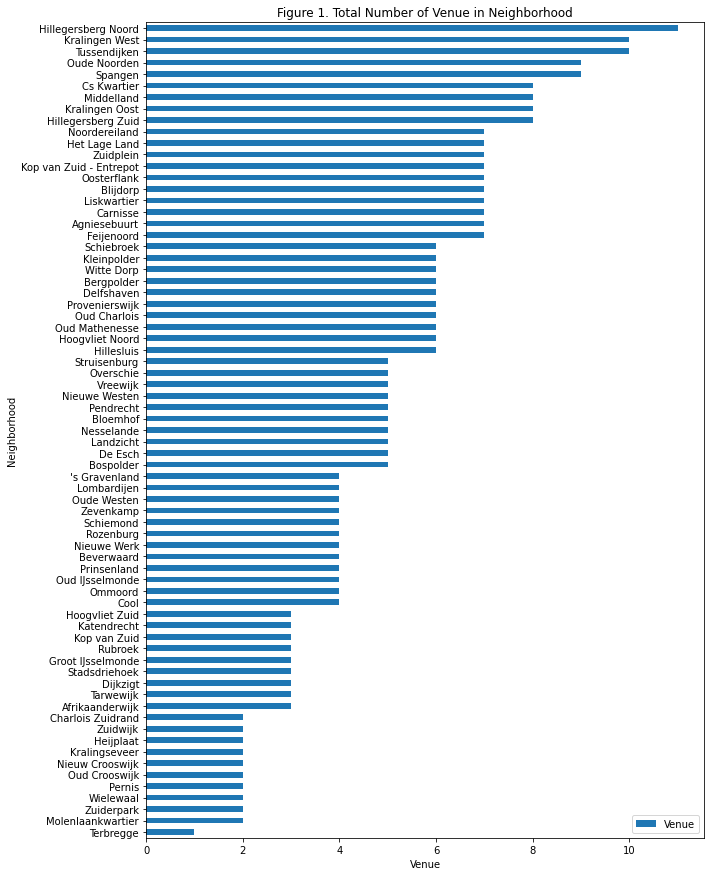

In [17]:
# check how many venues were returned for each neighborhood
rtm_venues_bar = rtm_select.groupby('Neighborhood').count()

rtm_venues_bar_select = rtm_venues_bar[['Venue']]
sort = rtm_venues_bar_select.sort_values(by='Venue')

# step 2: plot data in bar chart
sort.plot(kind='barh', figsize=(10, 15))

plt.ylabel('Neighborhood') 
plt.xlabel('Venue')
plt.title('Figure 1. Total Number of Venue in Neighborhood') # add title to the plot

plt.show()


The above bar chart shows that some of the neighborhoods such Spangen, Tussendijken and Hillegersberg Noord return higher numbers of selected venues in the given geospatial coordinates. That means these neighborhoods may match our selected categories.

The result may reflect all the possible venues in the neighborhoods captured by Foursquare. The results, oboviously, heavily depends on the information given by the Foursquare users including its geospatial coordinates of latitude and longitude. In this case, for given latitude and longitude of a neighborhood, the system will try to find venues within 750m-vicinity of the neighborhood. Depending on the distance between neighborhoods, one venue may be included in more neighborhoods. 

## Analysis <a name="analysis"></a>

Now let's do some analysis for each neighborhood and see how the selected categories are distributed in that neighborhoods. For this we generate one hot encoding. For a given neighborhood, venue category existing in that neighborhood will be denoted by non-zero entry in the column matrix categories as seen in below **Table 5**.

In [18]:
# one hot encoding
rtm_onehot = pd.get_dummies(rtm_select[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rtm_onehot['Neighborhood'] = rtm_select['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rtm_onehot.columns[-1]] + list(rtm_onehot.columns[:-1])
rtm_onehot = rtm_onehot[fixed_columns]

rtm_onehot.head()

rtm_grouped = rtm_onehot.groupby('Neighborhood').mean().reset_index()
rtm_grouped


Neighborhood  Bus Station  Bus Stop  Business Service  \
0             's Gravenland         0.25  0.250000             0.000   
1           Afrikaanderwijk         0.00  0.000000             0.000   
2              Agniesebuurt         0.00  0.000000             0.000   
3                Bergpolder         0.00  0.000000             0.000   
4                Beverwaard         0.00  0.500000             0.000   
5                  Blijdorp         0.00  0.142857             0.000   
6                  Bloemhof         0.00  0.000000             0.000   
7                 Bospolder         0.00  0.000000             0.000   
8                  Carnisse         0.00  0.000000             0.000   
9         Charlois Zuidrand         0.00  0.000000             0.000   
10                     Cool         0.00  0.000000             0.000   
11              Cs Kwartier         0.00  0.000000             0.000   
12                  De Esch         0.00  0.000000             0.000   
13               Delfshaven         0.00  0.000000             0.000   
14                 Dijkzigt         0.00  0.000000             0.000   
15               Feijenoord         0.00  0.285714             0.000   
16        Groot IJsselmonde         0.00  0.000000             0.000   
17                Heijplaat         0.00  0.500000             0.000   
18            Het Lage Land         0.00  0.142857             0.000   
19      Hillegersberg Noord         0.00  0.000000             0.000   
20       Hillegersberg Zuid         0.00  0.125000             0.000   
21               Hillesluis         0.00  0.000000             0.000   
22          Hoogvliet Noord         0.00  0.166667             0.000   
23           Hoogvliet Zuid         0.00  0.000000             0.000   
24              Katendrecht         0.00  0.000000             0.000   
25              Kleinpolder         0.00  0.333333             0.000   
26             Kop van Zuid         0.00  0.000000             0.000   
27  Kop van Zuid - Entrepot         0.00  0.285714             0.000   
28           Kralingen Oost         0.00  0.000000             0.000   
29           Kralingen West         0.00  0.000000             0.000   
30            Kralingseveer         0.00  0.500000             0.000   
31                Landzicht         0.00  0.600000             0.000   
32              Liskwartier         0.00  0.000000             0.000   
33              Lombardijen         0.00  0.250000             0.000   
34               Middelland         0.00  0.125000             0.125   
35        Molenlaankwartier         0.00  0.000000             0.000   
36               Nesselande         0.00  0.000000             0.000   
37          Nieuw Crooswijk         0.00  0.000000             0.000   
38              Nieuwe Werk         0.00  0.000000             0.000   
39            Nieuwe Westen         0.00  0.200000             0.200   
40            Noordereiland         0.00  0.285714             0.000   
41                  Ommoord         0.00  0.000000             0.000   
42              Oosterflank         0.00  0.142857             0.000   
43             Oud Charlois         0.00  0.333333             0.000   
44            Oud Crooswijk         0.00  0.000000             0.000   
45          Oud IJsselmonde         0.00  0.500000             0.000   
46           Oud Mathenesse         0.00  0.333333             0.000   
47             Oude Noorden         0.00  0.111111             0.000   
48              Oude Westen         0.00  0.000000             0.000   
49                Overschie         0.00  0.600000             0.000   
50                Pendrecht         0.00  0.200000             0.000   
51                   Pernis         0.00  0.500000             0.000   
52              Prinsenland         0.00  0.250000             0.000   
53           Provenierswijk         0.00  0.000000             0.000   
54                Rozenburg         0.00  0.000000     

By merging **Table 5** with selected columns from **Table 1** we receive the following **Table 6**.

In [19]:
#merge rtm_group with rtm_select
rtm_merged = df_rtm_select.iloc[:,:] # lat lon to be added

rtm_merged = rtm_merged.join(rtm_grouped.set_index('Neighborhood'), on='Neighborhood')

In [20]:
rtm_merged = rtm_merged.drop('Postal Code',axis = 1)
rtm_merged = rtm_merged.dropna(axis = 0, how ='any') 

rtm_merged.head()

Neighborhood  Population Density per km2  \
0  Stadsdriehoek                       12065   
1           Cool                        9404   
2    Cs Kwartier                        2511   
3    Oude Westen                       16682   
4       Dijkzigt                        1382   

   %-age building constructed before 2000  \
0                                      74   
1                                      85   
2                                     100   
3                                      98   
4                                      83   

   %-age building constructed after 2000  Average House Price in K€  \
0                                     26                        275   
1                                     15                        233   
2                                      0                        264   
3                                      2                        188   
4                                     17                        162   

    Latitude  Longitude  Bus Station  Bus Stop  Business Service  Drugstore  \
0  51.917657   4.488733          0.0       0.0               0.0        0.0   
1  51.917812   4.475448          0.0       0.0               0.0        0.0   
2  51.924428   4.469980          0.0       0.0               0.0        0.0   
3  51.918257   4.468022          0.0       0.0               0.0        0.0   
4  51.912476   4.467651          0.0       0.0               0.0        0.0   

   Forest  Grocery Store  Lake  Organic Grocery      Park  Pharmacy  \
0     0.0       0.000000   0.0         0.666667  0.000000       0.0   
1     0.0       0.250000   0.0         0.000000  0.250000       0.0   
2     0.0       0.125000   0.0         0.000000  0.000000       0.0   
3     0.0       0.250000   0.0         0.000000  0.250000       0.0   
4     0.0       0.333333   0.0         0.000000  0.666667       0.0   

   Skate Park  Supermarket  Theme Park  Theme Park Ride / Attraction  \
0         0.0        0.000         0.0                           0.0   
1         0.0        0.500         0.0                           0.0   
2         0.0        0.625         0.0                           0.0   
3         0.0        0.250         0.0                           0.0   
4         0.0        0.000         0.0                           0.0   

   Train Station  Tram Station  Water Park  
0          0.000      0.333333         0.0  
1          0.000      0.000000         0.0  
2          0.125      0.125000         0.0  
3          0.250      0.000000         0.0  
4          0.000      0.000000         0.0

So now we have the required data for the Cluster analysis, i.e. the population density, the percentage distribution of new buildings, the average housing price, and the location information, i.e. short distance to essential places and nearby nature.

Having **Table 6** above, we are now interested in creating clusters within the neighborhoods of Rotterdam. Clustering or segmentation is the practice of partitioning a dataset into subsets that have similar characteristics. One of the algorithms that can be used for clustering is K-means clustering. K-means can group data based on the similarity of the objects within the dataset to each other.

Select the criteria we want to use as Clusters. Check the optimum choice of cluster k by using K-Elbow method

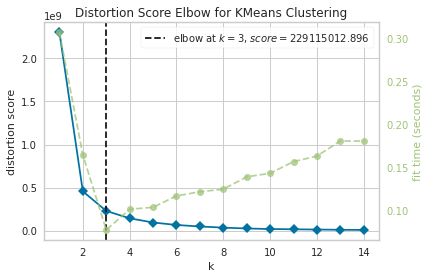

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# instantiate the model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1,15))

X = rtm_merged.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)

visualizer.fit(X) # fit data to visualizer
visualizer.poof() # draw/show/poof the data

From above graph we see that optimum k is 3. By setting k=3, we calculate the label of each neighborhood and add them into a column name Cluster Labels

In [21]:
# set number of clusters
kclusters = 3

XX = rtm_merged.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(XX)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

In [22]:
# add clustering labels

rtm_merged.insert(5, 'Cluster Labels', kmeans.labels_)

rtm_merged.head()

Neighborhood  Population Density per km2  \
0  Stadsdriehoek                       12065   
1           Cool                        9404   
2    Cs Kwartier                        2511   
3    Oude Westen                       16682   
4       Dijkzigt                        1382   

   %-age building constructed before 2000  \
0                                      74   
1                                      85   
2                                     100   
3                                      98   
4                                      83   

   %-age building constructed after 2000  Average House Price in K€  \
0                                     26                        275   
1                                     15                        233   
2                                      0                        264   
3                                      2                        188   
4                                     17                        162   

   Cluster Labels   Latitude  Longitude  Bus Station  Bus Stop  \
0               2  51.917657   4.488733          0.0       0.0   
1               2  51.917812   4.475448          0.0       0.0   
2               1  51.924428   4.469980          0.0       0.0   
3               0  51.918257   4.468022          0.0       0.0   
4               1  51.912476   4.467651          0.0       0.0   

   Business Service  Drugstore  Forest  Grocery Store  Lake  Organic Grocery  \
0               0.0        0.0     0.0       0.000000   0.0         0.666667   
1               0.0        0.0     0.0       0.250000   0.0         0.000000   
2               0.0        0.0     0.0       0.125000   0.0         0.000000   
3               0.0        0.0     0.0       0.250000   0.0         0.000000   
4               0.0        0.0     0.0       0.333333   0.0         0.000000   

       Park  Pharmacy  Skate Park  Supermarket  Theme Park  \
0  0.000000       0.0         0.0        0.000         0.0   
1  0.250000       0.0         0.0        0.500         0.0   
2  0.000000       0.0         0.0        0.625         0.0   
3  0.250000       0.0         0.0        0.250         0.0   
4  0.666667       0.0         0.0        0.000         0.0   

   Theme Park Ride / Attraction  Train Station  Tram Station  Water Park  
0                           0.0          0.000      0.333333         0.0  
1                           0.0          0.000      0.000000         0.0  
2                           0.0          0.125      0.125000         0.0  
3                           0.0          0.250      0.000000         0.0  
4                           0.0          0.000      0.000000         0.0

Group the cluster and do the analysis

#### Population Density

In [23]:
cluster_0 = rtm_merged.loc[rtm_merged['Cluster Labels'] ==0]
cluster_1 = rtm_merged.loc[rtm_merged['Cluster Labels'] ==1]
cluster_2 = rtm_merged.loc[rtm_merged['Cluster Labels'] ==2]

In [24]:
pop_0     = cluster_0.set_index('Neighborhood')
pop_1     = cluster_1.set_index('Neighborhood')
pop_2     = cluster_2.set_index('Neighborhood')

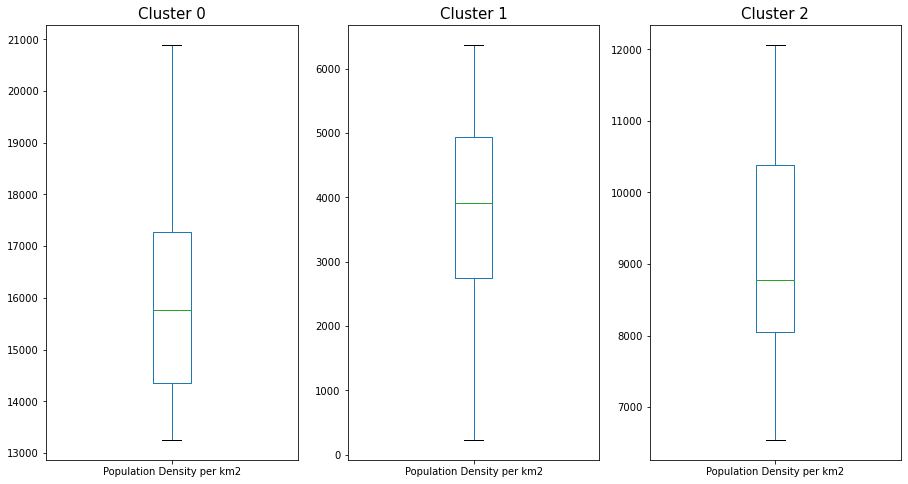

In [25]:
fig = plt.figure() # create figure
fig.tight_layout(h_pad=500)

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

pop_0['Population Density per km2'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax0)
ax0.set_title('Cluster 0', size=15)
ax0.set_ylabel('', size=20)

pop_1['Population Density per km2'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax1)
ax1.set_title('Cluster 1', size=15)
ax1.set_ylabel('', size=20)
plt.subplots_adjust(right=2.5)

pop_2['Population Density per km2'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax2)
ax2.set_title('Cluster 2', size=15)
ax2.set_ylabel('', size=20)


plt.show()


From box plot above we notice that neighborhoods in **Cluster 1** have in average higher population density than the ones in **Cluster 0** with factor of 2 and **Cluster 2** with factor of 4.

In [28]:
rtm_geo = r'https://github.com/fifidejong/Coursera_Capstone/raw/main/rotterdam_new.geojson' # geojson file

# create a plain world map
rtm_map1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate choropleth map 
rtm_map1.choropleth(
    geo_data=rtm_geo,
    data=rtm_merged,
    columns=['Neighborhood', 'Population Density per km2'],
    key_on='feature.properties.buurtnaam',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name = 'Population Density per km2',
    reset = True
)

# display map
rtm_map1

From the choropleth map above, it is clearly shown that neighborhoods located at center of Rotterdam are more densely populated than the ones e.g. along the river.

#### Percentage of new building

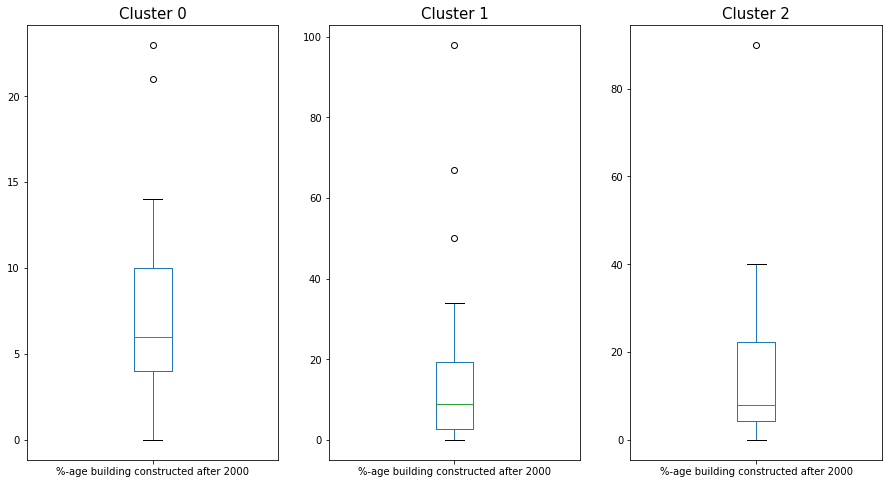

In [29]:
fig = plt.figure() # create figure
fig.tight_layout(h_pad=500)

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

pop_0['%-age building constructed after 2000'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax0)
ax0.set_title('Cluster 0', size=15)
ax0.set_xlabel('', fontsize=20)

pop_1['%-age building constructed after 2000'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax1)
ax1.set_title('Cluster 1', size=15)
ax1.set_xlabel('', fontsize=20)
plt.subplots_adjust(right=2.5)

pop_2['%-age building constructed after 2000'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax2)
ax2.set_title('Cluster 2', size=15)
ax2.set_xlabel('', fontsize=20)


plt.show()


Disregarding the outliers, from box plot above we notice that the median value of **Cluster 0** has similar level with **Cluster 2**. The set distribution however, it appears that **Cluster 0** is more stretched that **Cluster 2**, which likely to show that **Cluster 0** has more neighborhoods with high percentage of new buildings.

Since only small level of percentage shown in box plot above, **Cluster 1** would probably consists of neighborhoods with old building. I would suggest stakeholders who have interest in purchasing old/classic monument building can check this Cluster.

Now let's visualize the percentage distribution of new buildings in the neighborhoods of Rotterdam by using Folium library.

In [30]:
rtm_geo = r'https://github.com/fifidejong/Coursera_Capstone/raw/main/rotterdam_new.geojson' # geojson file

# create a plain world map
rtm_map5 = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate choropleth map 
rtm_map5.choropleth(
    geo_data=rtm_geo,
    data=rtm_merged,
    columns=['Neighborhood', '%-age building constructed after 2000'],
    key_on='feature.properties.buurtnaam',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name = '%-age building constructed after 2000',
    reset = True
)

# display map
rtm_map5

#### Housing Price

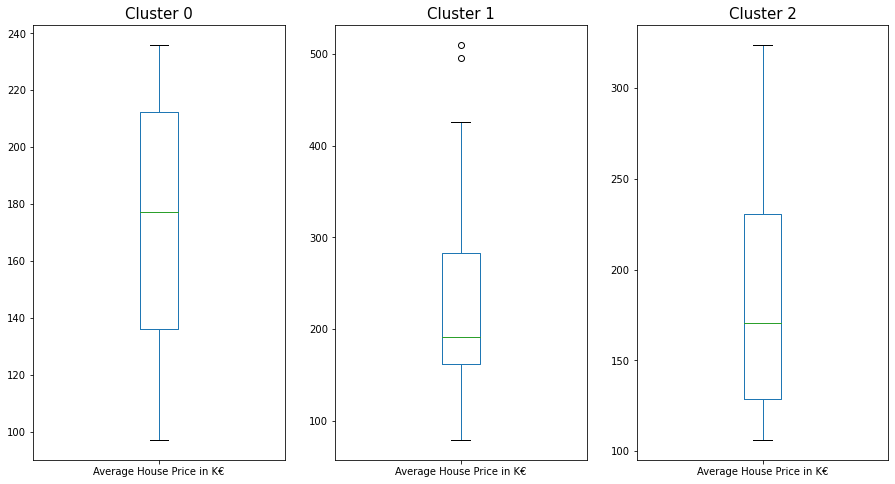

In [31]:
fig = plt.figure() # create figure
fig.tight_layout(h_pad=500)

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

pop_0['Average House Price in K€'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax0)
ax0.set_title('Cluster 0', size=15)
ax0.set_xlabel('', fontsize=20)

pop_1['Average House Price in K€'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax1)
ax1.set_title('Cluster 1', size=15)
ax1.set_xlabel('', fontsize=20)
plt.subplots_adjust(right=2.5)

pop_2['Average House Price in K€'].plot(kind='box',  vert = True, figsize=(5, 8),ax = ax2)
ax2.set_title('Cluster 2', size=15)
ax2.set_xlabel('', fontsize=20)


plt.show()



Based on the box plot above, neighborhoods in **Cluster 1** have average housing prices slightly lower than the **Cluster 0** and **Cluster 2** have neighborhoods with more expensive houses. This can be seen that there are 2 outliers in the Cluster.

Now let's visualize the house pricing distribution of the neighborhoods in Rotterdam by using Folium to generate choropleth map.

In [32]:
rtm_geo = r'https://github.com/fifidejong/Coursera_Capstone/raw/main/rotterdam_new.geojson' # geojson file

# create a plain world map
rtm_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate choropleth map 
rtm_map.choropleth(
    geo_data=rtm_geo,
    data=rtm_merged,
    columns=['Neighborhood', 'Average House Price in K€'],
    key_on='feature.properties.buurtnaam',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name = 'Average House Price (k-EUR)',
    reset = True
)


# display map
rtm_map

#### Venue types in Neighborhood

In this analysis, we use inferential statistics generated for each Cluster. Next, we sort the median (mean) value of all selected venue types for the analysis. Then we choose the top five median values of the venue types. 

In [33]:
import operator

location_0 = cluster_0.describe()
location_1 = cluster_1.describe()
location_2 = cluster_2.describe()

MaxKey_0 = sorted(location_0.iloc[1,7:].items(), key = operator.itemgetter(1),reverse=True)[:5]
print("Top 5 venue types in Cluster 0 and its Median Value = \n ",MaxKey_0)

MaxKey_1 = sorted(location_1.iloc[1,7:].items(), key = operator.itemgetter(1),reverse=True)[:5]
print("Top 5 venue types in Cluster 1 and its Median Value = \n ",MaxKey_1)

MaxKey_2 = sorted(location_2.iloc[1,7:].items(), key = operator.itemgetter(1),reverse=True)[:5]
print("Top 5 venue types in Cluster 2 and its Median Value = \n ",MaxKey_2)

Top 5 venue types in Cluster 0 and its Median Value = 
  [('Supermarket', 0.4474810213940648), ('Tram Station', 0.1331262939958592), ('Drugstore', 0.09784334023464458), ('Park', 0.08899240855762594), ('Bus Stop', 0.06312974465148377)]
Top 5 venue types in Cluster 1 and its Median Value = 
  [('Supermarket', 0.3160004058441558), ('Park', 0.19035443722943723), ('Bus Stop', 0.14799107142857143), ('Drugstore', 0.12272050865800865), ('Tram Station', 0.09897186147186146)]
Top 5 venue types in Cluster 2 and its Median Value = 
  [('Supermarket', 0.3808035714285714), ('Tram Station', 0.1777529761904762), ('Bus Stop', 0.14501488095238094), ('Drugstore', 0.12336309523809524), ('Park', 0.06830357142857142)]


From the results above we observe that all Clusters are dominated by 'Supermarket' type of venue. This can be translated that all neighborhoods in the Clusters most definitely have Supermarket in their vicinity. 

In [34]:
# plot the above results to better visualise
Y0 = np.empty((5,1))
Y1 = np.empty((5,1))
Y2 = np.empty((5,1))
for i in range(5):
        Y0[i] = MaxKey_0[i][1]
        Y1[i] = MaxKey_1[i][1]
        Y2[i] = MaxKey_2[i][1]
        
X0 = ['Supermarket','Tram Station','Bus Stop','Drugstore','Park']
X1 = ['Supermarket','Tram Station','Drugstore','Park','Bus Stop']
X2 = ['Supermarket','Park','Bus Stop','Drugstore','Tram Station']

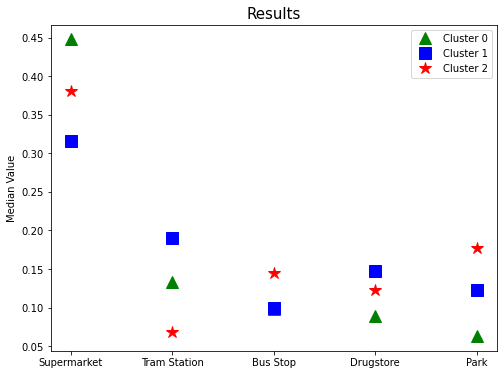

In [35]:
fig = plt.figure(figsize=(8,6)) # create figure

plt.plot(X0, Y0,'g^' ,markersize=12)
plt.plot(X1, Y1,'bs', markersize=12)
plt.plot(X2, Y2,'r*', markersize=12)
plt.legend(['Cluster 0','Cluster 1', 'Cluster 2'] , fontsize=10)
plt.title('Results', size=15)

plt.ylabel('Median Value', fontsize=10)
plt.show()

From above results we see that most of the Clusters have high median value for Supermarket. This may due to the fact that neighborhoods in the Clusters have many supermarkets available in the vicinity of the neighborhoods. What is quite interesting is that Cluster 0 gives very low on Park so we may conclude that we may get less chance to get neighborhoods in Cluster 0 located nearby park. 

Cluster 1 will probably a typical residential areas with available daily essential stores within reach from the house. The neighborhoods in this cluster have easy access to public transport and with moderate distance to park (nature).

In Cluster 2 we may find quiet neighborhoods with moderate number of essential stores, less access to public transport but will be surrounded by nature (here e.g. park)

Let's visualize the resulting Clusters. Before doing so, ensure the dataframe has the required geospatial coordinates.

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rtm_merged['Latitude'], rtm_merged['Longitude'], rtm_merged['Neighborhood'], rtm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

This concludes our analysis. We have acquired governmental data to build a guideline to find the best neighborhoods to live in Rotterdam. We have set certain criteria for neighborhood selection. We further do perform cluster analysis based on the selection criteria, i.e. location (close to nature and within reach to essential places), population density, average house pricing and percentage of new houses in the neighborhood.

## Results and Discussion <a name="results"></a>

Our analysis shows the following
* Cluster 0: 
    * Rotterdam busiest neighborhoods where highstreets located with lots of available daily essential stores 
    * Easy access to public transport
    * Not surrounded by nature
    
* Cluster 1: 
    * Rotterdam residential areas with available daily essential stores within reach of the houses 
    * Easy access to public transport
    * Moderately surrounded by nature (park)
        
* Cluster 2: 
    * Rotterdam residential areas quite far from hustle-bustle areas with moderate number of essential stores
    * Less access to public transport (tram)
    * Surrounded by nature (park)


## Conclusion <a name="conclusion"></a>

* Data have been acquired to build a guideline of finding best neighborhoods to live in Rotterdam
* Criteria have been set for the neighborhood selection
* Cluster analysis has been conducted to analyze neighborhoods based on the selection criteria (location, population density, average house price, percentage of new houses in the area)
* From the analysis we conclude that neighborhoods in Cluster 2 may be the best fit for the given criteria because:
    * affordable house price
    * moderate availability of new building
    * not that densely populated
    * close vicinity to nature
* Neighborhood’s examples from Cluster 2 are Hillegersberg Zuid, Agniesebuurt and Oosterflank.
